In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import logging
import networkx as nx
import os
import h5py
import matplotlib.pyplot as plt
import torch.optim as optim
import time
import math
import os, sys
import seaborn as sns
import warnings
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
# from MaxMin_Norm import MinMaxNormalization
from torch.utils.data import TensorDataset, DataLoader
sys.path.append('../data_process/')
warnings.filterwarnings("ignore")
import pickle


In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=False,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        self.relu = nn.ReLU(inplace = True)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [3]:
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)
    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)
class CoordAtt(nn.Module):
    def __init__(self, inp, oup, reduction):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))

        mip = max(8, inp // reduction)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = h_swish()

        self.conv_h = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        identity = x

        n, c, h, w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)
    
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)
        
        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()
# 如果下面这个原论文代码用不了的话，可以换成另一个试试
        out = identity * a_w * a_h 
        # out = a_h.expand_as(x) * a_w.expand_as(x) * identity

        return out
class Channelsa(nn.Module):
    def __init__(self):
        super(Channelsa,self).__init__()
        self.fc = nn.Linear(60, 60)
        self.fc1 = nn.Linear(60, 60)
        self.fc2 = nn.Linear(60, 60)
    def forward(self,z):
        z = z.reshape(-1,60,128)
        z = z.permute(0, 2, 1) 
        Qs = self.fc(z)
        Ks = self.fc1(z).permute(0, 2, 1) 
        Vs = self.fc2(z)
        attention_scores = torch.matmul(Qs, Ks)
        attention_scores = attention_scores / math.sqrt(60)
        attention_scores = nn.Softmax(dim=-1)(attention_scores)
        z = torch.matmul(attention_scores, Vs)
        z = z.permute(0, 2, 1)
        z = z.reshape(-1,60,16,8)
        return z

In [20]:
class ResUnit(nn.Module):
    def __init__(self, in_channels, out_channels, lng, lat):
        # 模型的输入是一个四维张量 (B, C, lng, lat)
        super(ResUnit, self).__init__()
        self.bn1 = nn.BatchNorm2d(60)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv1d = nn.Conv1d(128,128,1,1,0)
        self.bn2 = nn.BatchNorm2d(60)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.relu = nn.ReLU(inplace = True)
        self.fc = nn.Linear(128, 128)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc0 = nn.Linear(60, 128)
        self.CoordAtt = CoordAtt(60,60,4)
        # 分别定义两个批归一化层和卷积层
    def forward(self, x):
        z = F.relu(self.bn1(x))
        z = self.conv1(z)
        z = F.relu(self.bn2(z))
        z = self.conv2(z)
        z = z.reshape(-1,60,128)
        Qs = self.fc(z)
        Ks = self.fc1(z).permute(0, 2, 1) 
        Vs = self.fc2(z)
        attention_scores = torch.matmul(Qs, Ks)
        attention_scores = attention_scores / math.sqrt(128)
        attention_scores = nn.Softmax(dim=-1)(attention_scores)
        z = torch.matmul(attention_scores, Vs)
#         z = self.fc0(z)
        z = z.reshape(-1,60,16,8)
        z = self.CoordAtt(z)
        out = x+z
        return out 

In [21]:
class Branch_net(nn.Module):
    def __init__(self, num_res_unit, input_lenght, flow_channel, grid_heigh, grid_width,in_channels):
        super(Branch_net, self).__init__()
        self.num_res_unit = num_res_unit
        self.input_lenght = input_lenght
        self.flow_channel = flow_channel
        self.grid_heigh = grid_heigh
        self.grid_width = grid_width
        self.in_channels = in_channels
        # 每个分支网络的首部都是用一个卷积网络将输入的特征维度从低维映射到高维
        self.branch_net = nn.ModuleList([ResUnit(60,60, self.grid_heigh, self.grid_width)])
#         nn.ModuleList([nn.Conv2d(self.in_channels, 80, kernel_size=3, stride=1, padding=1)])
#         self.branch_net.append(nn.Conv2d(self.in_channels, 80, kernel_size=3, stride=1, padding=1))
        # 接下来依次添加多个残差卷积单元
        for i in range(1): 
            self.branch_net.append(ResUnit(60, 60, self.grid_heigh, self.grid_width))
        self.branch_net.append(nn.Conv2d(60, 2, kernel_size=3,stride = 1, padding = 1)) 
    # 分支网络的前向传播
    def forward(self, x):
        for layer in self.branch_net:
             x = layer(x)
        return x 
class STEResUnit1(nn.Module):
    def __init__(self, in_channels, out_channels, i):
        super(STEResUnit1,self).__init__()
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.i=i
        self.conv3d0  = nn.Conv3d(in_channels, out_channels, kernel_size=(1,3,3), dilation =(1,1,1), stride=1, padding='same')
        self.conv3d00  = nn.Conv3d(out_channels, out_channels, kernel_size=(3,1,1), dilation =(1,1,1), stride=1, padding='same')
    def forward(self,x):
        x0 = self.conv3d0(x)
        X= self.conv3d00(x0)
        X = F.relu(self.bn1(X))
        if self.i ==True:
            return X
        else:
            return torch.cat((X,x),1)

class DenseNet(nn.Sequential):
    """DenseBlock"""
    def __init__(self, num_layers, num_input_features,num_output):
        super(DenseNet, self).__init__() 
        for i in range(num_layers):
            r = False
            if i ==num_layers-1:
                r = True
            layer = STEResUnit1(num_input_features+i*num_output, num_output,r)
            self.add_module("denselayer%d" % (i+1), layer)
    def forward(self, x):
        out = super(DenseNet, self).forward(x)
        return out

In [22]:
class Model(nn.Module):
    def __init__(self,lr=0.01,epoch=10, #训练轮次数
                 batch_size=32, #批训练batch大小
                 c_length=3, #邻近性时间流量特征序列默认长度
                 p_length=348654684896, #周期性时间流量特征序列默认长度
                 t_length=2,  #趋势性时间流量特征序列默认长度
                 external_dim=28, #外部特征的维度
                 grid_heigh=32, #网格图的高度
                 grid_width=32, #网格图的宽度
                 flow_channel=2, #流量种类
                 num_res_unit=2, #设定残差卷积单元的数量
                 in_channels = 6,
                 data_min = -10000,  # 输入数据的最小值默认值
                 data_max = 10000):
        super(Model, self).__init__()
        self.epoch = epoch  
        self.lr = lr
        self.batch_size = batch_size
        self.c_length = c_length
        self.p_length = p_length
        self.t_length = t_length
        self.external_dim = external_dim
        self.grid_heigh = grid_heigh
        self.grid_width = grid_width
        self.in_channels = in_channels
        self.flow_channel  = flow_channel 
        self.num_res_unit = num_res_unit
        self.logger = logging.getLogger(__name__)
        self.data_min = data_min
        self.data_max = data_max
        self.gpu_available = torch.cuda.is_available()
        if self.gpu_available:  #如果GPU存在，则调用
            self.gpu = torch.device("cuda:0")
        self.backbone_net()
        self.save_path="L%d_C%d_P%d_T%d/"% (self.num_res_unit,self.c_length, self.p_length, self.t_length)
        self.best_mse = 10000
    def backbone_net(self):
        self.c_net = Branch_net(self.num_res_unit,self.c_length,
                     self.flow_channel, self.grid_heigh, self.grid_width,80) 
        self.bn1 = nn.BatchNorm2d(31)
        self.STERes = DenseNet(2,32,32)
#         self.STERes1 = DenseNet(1,8,8)
        self.conv3D1 = nn.Conv3d(2, 32, kernel_size=(1,1,1), stride=1, padding='same')
        self.conv3D2 = nn.Conv3d(32, 2, kernel_size=(1,1,1), stride=1, padding='same')
        self.conv3D11 = nn.Conv3d(2, 2, kernel_size=(1,1,1), stride=1, padding='same')
        self.conv3D22 = nn.Conv3d(2, 2, kernel_size=(1,1,1), stride=1, padding='same')
        self.CoordAtt = CoordAtt(31,31,4)
        self.conv1 = nn.Conv2d(19, 60, 3, 1, 1)
        self.conv3 = nn.Conv2d(27, 2, 1, 1, 0)
        self.w_c = nn.Parameter(torch.randn((self.flow_channel,
                self.grid_heigh, self.grid_width)), requires_grad=True)
        self.w_p = nn.Parameter(torch.randn((self.flow_channel,
                self.grid_heigh, self.grid_width)), requires_grad=True)
        self.ext_net = nn.Sequential(
            nn.Linear(9, 15), 
            nn.ReLU(inplace = True),
            nn.Linear(15,1*self.grid_heigh*self.grid_width))
        self.wxt_net0 = nn.Sequential(
            nn.Linear(28, 28), 
            nn.ReLU(inplace = True),
            nn.Linear(28,2*self.grid_heigh*self.grid_width))
        self.lstm = LSTM(28,32,1,28)
    def forward(self, xc, xp, xt, ext):
        ext_out = self.ext_net(ext).view([-1, 1,
                                          self.grid_heigh, self.grid_width])
        xcin = xc[:,:11:2,:,:]
        xcin = xcin.reshape(-1,1,6,16,8)
        xcout = xc[:,1:12:2,:,:]
        xcout = xcout.reshape(-1,1,6,16,8)
        Xc = torch.cat((xcin,xcout),1)
        xpin = xp[:,:5:2,:,:]
        xpin = xpin.reshape(-1,1,3,16,8)
        xpout = xp[:,1:6:2,:,:]
        xpout = xpout.reshape(-1,1,3,16,8)
#         Xp = torch.cat((xpin,xpout),1)
        Xc = self.conv3D1(Xc)
        Xc = self.STERes(Xc)
        Xc = self.conv3D2(Xc)

#         Xp = self.conv3D11(Xp)
#         Xp = self.STERes1(Xp)
#         Xp = self.conv3D22(Xp)
#         Xp = Xp.reshape(-1, 6, 16, 8)
        Xc = Xc.reshape(-1,12,16,8)

        XC = torch.cat((Xc,xp,ext_out),1)
#         XC = F.relu(self.bn1(XC))
#         XC = self.CoordAtt(XC)
        XC = self.conv1(XC)
        XC = self.c_net(XC)
        XC = torch.tanh(XC)    
        return XC
    def train_model(self, train_loader, val_loader):
        optimizer = optim.Adam(self.parameters(),lr = self.lr)
        loss_func = nn.MSELoss() # 定义模型的优化器和损失函数
#         loss_func = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
        early_stop_threshold = 10 # 设定提前停止阈值
        epoch_count = 0
        start_time = time.time()
        for ep in range(self.epoch):
            loss_list = []
            self.train() # 启动模型训练
            for i, (xc, xp, xt, xe, y) in enumerate(train_loader):
                if self.gpu_available:
                    xc = xc.to(self.gpu)
                    xp = xp.to(self.gpu)
                    xt = xt.to(self.gpu)
                    xe = xe.to(self.gpu)
                    y = y.to(self.gpu)
                   
                ypred = self.forward(xc, xp, xt, xe)
                loss = loss_func(ypred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # 模型验证部分，根据验证集上的损失保存最优模型
            for i, (xc, xp, xt, xe, y) in enumerate(val_loader):
                if self.gpu_available:
                    xc = xc.to(self.gpu)
                    xp = xp.to(self.gpu)
                    xt = xt.to(self.gpu)
                    xe = xe.to(self.gpu)
                    y = y.to(self.gpu)
                ypred = self.forward(xc, xp, xt, xe)
#                 y = y.reshape(-1,2,1024)
#                 y = y.reshape(-1,1024,2)
                val_loss = loss_func(ypred, y)
                loss_list.append(val_loss.item())
                end_time = time.time() 
            val_mse = np.mean(loss_list)
            print("[%.2fs] ep %d val mse %.6f" %(end_time - start_time, ep, val_mse))
            if val_mse < self.best_mse: #保存当前更优模型参数
                self.save_model("ST-D3DDARN-BikeNYC")
                self.best_mse = val_mse
                epoch_count = 0
            else:
                epoch_count = epoch_count +1
#             if epoch_count >= early_stop_threshold:
#                 break  # 当超过提前停止阈值时整个循环结束
            self.eval() 
            for i, (xc, xp, xt, xe, y) in enumerate(test_loader):
                if self.gpu_available:
                    xc = xc.to(self.gpu)
                    xp = xp.to(self.gpu)
                    xt = xt.to(self.gpu)
                    xe = xe.to(self.gpu)
                    y = y.to(self.gpu)
                
                with torch.no_grad():
                    ypred = self.forward(xc, xp, xt, xe)
                # 采用RMSE和MAE作为模型评估的指标
#                 rmse = ((ypred - y) **2).mean().pow(1/2)
#                 mae = ((ypred - y).abs()).mean()
#                 # 将RMSE和MAE恢复到规范化之前的尺度
#                 rmse = rmse * (self.data_max - self.data_min)
#                 mae = mae * (self.data_max - self.data_min)
#                 rmse_list.append(rmse.item())
#                 mae_list.append(mae.item())
                ypred = ypred.cpu().numpy()
                y = y.cpu().numpy()
                if i == 0:
                    ypred1 = ypred
                    y1 = y
                else:
                    y1 = np.concatenate((y1,y),axis=0)
                    ypred1 = np.concatenate((ypred1,ypred),axis=0)
            y = [inverse_transform(d) for d in y1]
            ypred = [inverse_transform(d) for d in ypred1]
            y1 = np.array(y).reshape(43008)
            ypred1 = np.array(ypred).reshape(43008)
            print(np.sqrt(metrics.mean_squared_error(ypred1, y1)))
            print(metrics.mean_absolute_error(ypred1, y1))
            LISTRMSE.append(np.sqrt(metrics.mean_squared_error(ypred1, y1)))
            LISTMAE.append(metrics.mean_absolute_error(ypred1, y1))
    # 模型的评估测试集启动部分
    def test_model(self, test_loader):
        rmse_list = []
        mae_list = []
        self.eval() # 启动模型评估（固定BN层参数）
        for i, (xc, xp, xt, xe, y) in enumerate(test_loader):
            if self.gpu_available:
                xc = xc.to(self.gpu)
                xp = xp.to(self.gpu)
                xt = xt.to(self.gpu)
                xe = xe.to(self.gpu)
                y = y.to(self.gpu)
             
            with torch.no_grad():
                ypred = self.forward(xc, xp, xt, xe)
            # 采用RMSE和MAE作为模型评估的指标
            rmse = ((ypred - y) **2).mean().pow(1/2)
            mae = ((ypred - y).abs()).mean()
            # 将RMSE和MAE恢复到规范化之前的尺度
            rmse = rmse * (self.data_max - self.data_min)
            mae = mae * (self.data_max - self.data_min)
            rmse_list.append(rmse.item())
            mae_list.append(mae.item())
            ypred = ypred.cpu().numpy()
            y = y.cpu().numpy()
            if i == 0:
                ypred1 = ypred
                y1 = y
            else:
                y1 = np.concatenate((y,y1),axis=0)
                ypred1 = np.concatenate((ypred,ypred1),axis=0)
        
        mae_test = np.mean(mae_list)
        rmse_test = np.mean(rmse_list)
        return rmse_test, mae_test, ypred1, y1
    
    # 模型保存代码
    def save_model(self, name):
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)
        torch.save(self.state_dict(), self.save_path + name + ".pkl")
    
    # 读取已保存的模型
    def load_model(self, name):
        if not name.endswith(".pkl"):
            name += ".pkl"
        self.load_state_dict(torch.load(self.save_path + name)) 

In [23]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
gpu_available = torch.cuda.is_available()
print(torch.cuda.is_available())
if gpu_available:
    gpu = torch.device("cuda:0")
    print(1)

cuda
True
1


In [24]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

In [25]:
LISTRMSE=[]
LISTMAE=[]
def inverse_transform(X):
    X = (X + 1.) / 2.
    X = 1. * X * (267 - 0) + 0
    return X
for i in range(1):
    if __name__ == '__main__':
        logging.basicConfig(level=logging.DEBUG,format='%(levelname)s-%(message)s')
        # 为模型中所有超参数赋值
        epochs = 60  # 训练的轮次数
        batch_size = 32 # 训练批次大小
        T = 48  # 一天内的时间片段划分
        c_length = 6  # 临近性序列长度
        p_length = 1  # 周期性序列长度
        t_length = 1  # 趋势性序列长度
        grid_height, grid_width = 16, 8  # 网格图的规格
        flow_channel = 2 # 流量类别数
        lr = 0.0005  # 学习率
        external_dim = 28 #额外特征维度
        num_res_unit = 2  # 卷积残差单元个数

        # 读取训练,验证和测试数据（分别需读入临近性，周期性，趋势性，额外特征数据已经标签数据）
        c_train =  np.load('BikeNYC/c_train.npy')
        p_train = np.load('BikeNYC/p_train.npy')
        t_train = np.load('BikeNYC/t_train.npy')
        e_train = np.load('BikeNYC/e_train.npy')
        train_y = np.load('BikeNYC/train_y.npy')
        c_val =  np.load('BikeNYC/c_val.npy')
        p_val = np.load('BikeNYC/p_val.npy')
        t_val = np.load('BikeNYC/t_val.npy')
        e_val = np.load('BikeNYC/e_val.npy')
        val_y = np.load('BikeNYC/val_y.npy')
        c_test = np.load('BikeNYC/c_test.npy')
        p_test = np.load('BikeNYC/p_test.npy')
        t_test = np.load('BikeNYC/t_test.npy')
        e_test = np.load('BikeNYC/e_test.npy')
        test_y = np.load('BikeNYC/test_y.npy')

    #     print(len(P2),len(C3))
        # 读取已保存的归一化数据转换器
        with open ('../data_process/data/preprocessing.pkl', 'rb') as f:
         scale = pickle.load(f)  
    #     print(c_train.shape,p_train.shape,t_train.shape,P.shape,C1.shape)
        # 将训练集/验证集/测试集都整理成pytorch的输入格式
        train_set = TensorDataset(torch.Tensor(c_train),torch.Tensor(p_train),torch.Tensor(t_train), 
                torch.Tensor(e_train), torch.Tensor(train_y))
        val_set = TensorDataset(torch.Tensor(c_val),torch.Tensor(p_val),torch.Tensor(t_val),
               torch.Tensor(e_val), torch.Tensor(val_y))
        test_set = TensorDataset(torch.Tensor(c_test),torch.Tensor(p_test),torch.Tensor(t_test),
               torch.Tensor(e_test),  torch.Tensor(test_y))

        # 装载训练集/验证集/测试集数据
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True,drop_last=False)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle = False)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle = False,drop_last=False)

        # 定义模型
        net = Model(lr = lr, epoch = epochs, batch_size = batch_size, 
                   c_length = c_length, p_length = p_length, t_length = t_length, 
                   external_dim = external_dim, grid_heigh = grid_height, 
                   grid_width = grid_width, flow_channel = flow_channel, 
                   num_res_unit = num_res_unit, data_min = scale._min, data_max = scale._max)
        if gpu_available:
            net = net.to(gpu)
        # 训练模型
        net.train_model(train_loader, val_loader)
        print('test model....')
        net.load_model("ST-D3DDARN-BikeNYC") # 读取最优模型
        rmse, mae,ypred,y  = net.test_model(test_loader) #用验证集上最好的模型进行测试评估
        print('RMSE=', rmse.item(), 'MAE=', mae.item())
        y = [inverse_transform(d) for d in y]
        ypred = [inverse_transform(d) for d in ypred]
        y1 = np.array(y).reshape(43008)
        ypred1 = np.array(ypred).reshape(43008)
        print(np.sqrt(metrics.mean_squared_error(ypred1, y1)))
        print(metrics.mean_absolute_error(ypred1, y1))
#         LISTRMSE.append(np.sqrt(metrics.mean_squared_error(ypred1, y1)))
#         LISTMAE.append(metrics.mean_absolute_error(ypred1, y1))

[2.00s] ep 0 val mse 0.006317
9.318404
4.796628
[3.66s] ep 1 val mse 0.003823
7.835826
3.9914482
[5.39s] ep 2 val mse 0.003500
7.351912
3.7127545
[7.13s] ep 3 val mse 0.002712
6.3231792
3.306796
[8.79s] ep 4 val mse 0.002555
6.218497
3.2949605
[10.47s] ep 5 val mse 0.002133
5.652193
2.9573858
[12.20s] ep 6 val mse 0.002100
5.7169094
2.9931133
[13.89s] ep 7 val mse 0.001984
5.4288344
2.8506546
[15.57s] ep 8 val mse 0.001984
5.626602
2.8571239
[17.25s] ep 9 val mse 0.001751
5.2423143
2.7641053
[19.01s] ep 10 val mse 0.001836
5.5058794
2.7854085
[20.72s] ep 11 val mse 0.001811
5.258736
2.7197552
[22.39s] ep 12 val mse 0.001792
5.422368
2.77633
[24.09s] ep 13 val mse 0.001655
5.3344216
2.849397
[25.84s] ep 14 val mse 0.001757
5.24869
2.6881478
[27.58s] ep 15 val mse 0.001654
5.013237
2.5754414
[29.30s] ep 16 val mse 0.001522
4.91422
2.5395062
[31.00s] ep 17 val mse 0.001623
4.874123
2.4969287
[32.67s] ep 18 val mse 0.001548
5.1331635
2.5970652
[34.35s] ep 19 val mse 0.001502
4.8475304
2.43

In [86]:
# np.save('ST-D3DDARNRMSE-BikeNYC',LISTRMSE)
# np.save('ST-D3DDARNMAE-BikeNYC',LISTMAE)
# net.load_model("ST-D3DDARN-BikeNYC") 
# rmse, mae,ypred,y= net.test_model(test_loader)
pre1 = np.load('BikeNYC/ST-D3DDARN-B-pre1.npy')
pre2 = np.load('BikeNYC/ST-D3DDARN-B-pre2.npy')
pre3 = np.load('BikeNYC/ST-D3DDARN-B-pre3.npy')
pre4 = np.load('BikeNYC/ST-D3DDARN-B-pre4.npy')
pre5 = np.load('BikeNYC/ST-D3DDARN-B-pre5.npy')
print(pre1.shape,pre2.shape)
c_test = np.load('BikeNYC/c_test.npy')
c_test = c_test[5:]
for i in range(163):
    c_test[i,2:4,:,:] = pre1[i]
    c_test[i,4:6,:,:] = pre2[i]
    c_test[i,6:8,:,:] = pre3[i]
    c_test[i,8:10,:,:] = pre4[i]
    c_test[i,10:,:,:] = pre5[i]
test_set = TensorDataset(torch.Tensor(c_test),torch.Tensor(p_test[5:]),torch.Tensor(t_test[5:]),
       torch.Tensor(e_test[5:]),  torch.Tensor(test_y[5:]))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle = False,drop_last=False)
rmse, mae,ypred,y= net.test_model(test_loader)
y=np.array(y).reshape(41728)
ypred = np.array(ypred).reshape(41728)
y = [inverse_transform(d) for d in y]
ypred = [inverse_transform(d) for d in ypred]
print(np.sqrt(metrics.mean_squared_error(y, ypred)))
print(metrics.mean_absolute_error(ypred, y))
# np.save('BikeNYC/ST-D3DDARN-B-pre5',ypred)
# # y = [inverse_transform(d) for d in y]
# ypred = [inverse_transform(d) for d in ypred]
# plt.figure(figsize=(8,16))
# sns.heatmap(data=abs(ypred[18][0]-y[18][0]),vmax=40,square=False,cbar=False, xticklabels=False,yticklabels=False,cmap="plasma_r")

(168, 2, 16, 8) (167, 2, 16, 8)
7.691514039010049
3.5458029552754757


DEBUG-locator: <matplotlib.ticker.AutoLocator object at 0x000001D08E1A91F0>


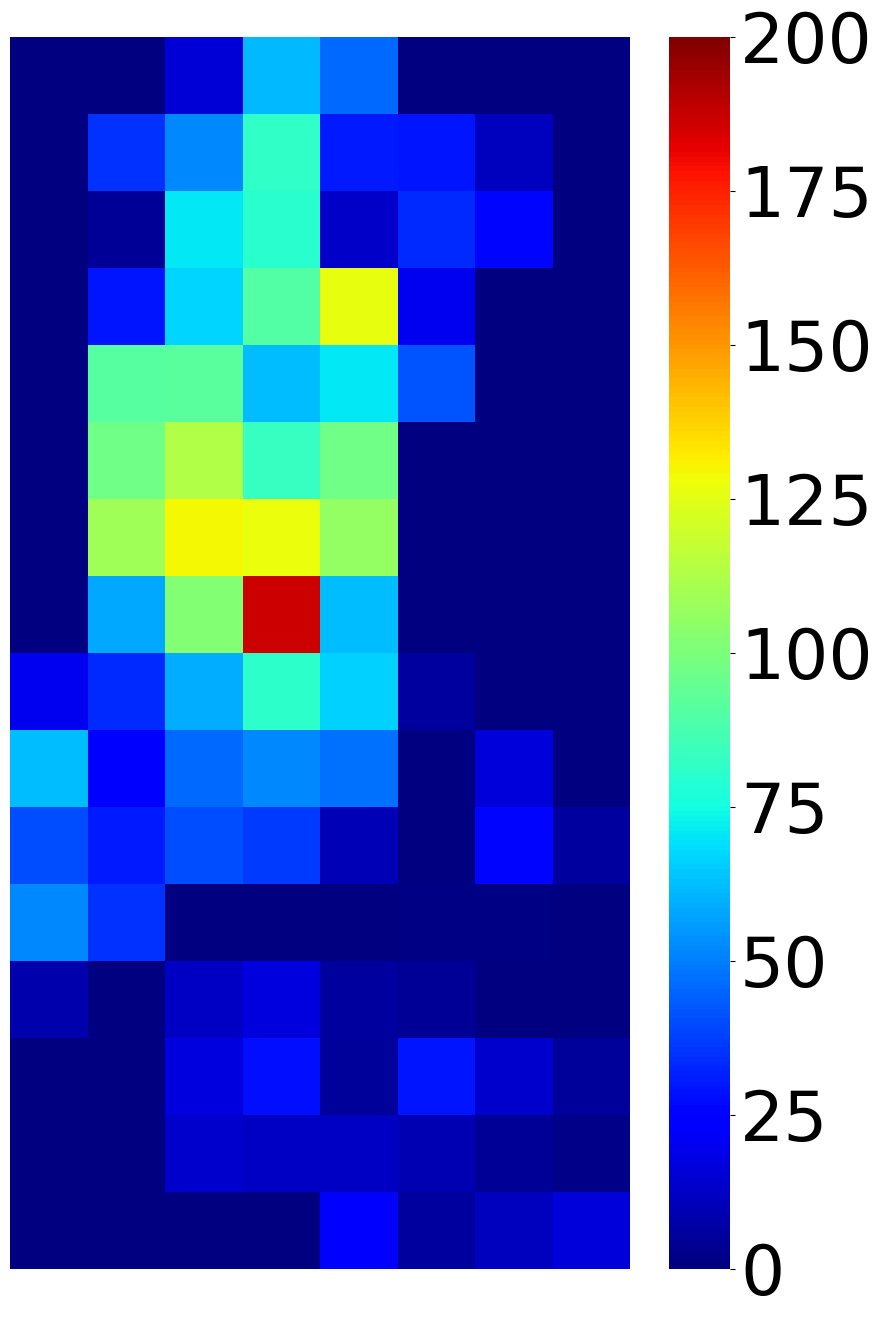

In [53]:
plt.figure(figsize=(10,16))
ax = sns.heatmap(data=y[18][0],vmax=200,square=False,cbar=True, xticklabels=False,yticklabels=False,cmap="jet")
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=50)

In [53]:
# print(np.mean(LISTMAE))
# print(np.mean(LISTRMSE))
net.load_model("ST-D3DDARN-BikeNYC") 
rmse, mae,ypred1,y1  = net.test_model(test_loader) 
y1in = y1[:,0,:,:]
y1out = y1[:,1,:,:]
ypred1in = ypred1[:,0,:,:]
ypred1out = ypred1[:,1,:,:]
ypred1in=np.array(ypred1in).reshape(21504)
ypred1out = np.array(ypred1out).reshape(21504)
y1in=np.array(y1in).reshape(21504)
y1out = np.array(y1out).reshape(21504)
y1in = [inverse_transform(d) for d in y1in]
ypred1in = [inverse_transform(d) for d in ypred1in]
y1out = [inverse_transform(d) for d in y1out]
ypred1out = [inverse_transform(d) for d in ypred1out]
print('inrmse',np.sqrt(metrics.mean_squared_error(y1in, ypred1in)))
print('inmae',metrics.mean_absolute_error(ypred1in, y1in))
print(np.sqrt(metrics.mean_squared_error(y1out, ypred1out)))
print(metrics.mean_absolute_error(ypred1out, y1out))

inrmse 4.448986515841659
inmae 2.2384171979265375
4.6572626531520465
2.287379904372114


In [74]:
rmse, mae,ypred1,y1  = net.test_model(test_loader) 
y1=np.array(y1).reshape(43008)
ypred1 = np.array(ypred1).reshape(43008)
y = [inverse_transform(d) for d in y1]
ypred = [inverse_transform(d) for d in ypred1]
# y=np.array(y).reshape(43008)
# ypred = np.array(ypred).reshape(43008)
print(np.sqrt(metrics.mean_squared_error(y, ypred)))
print(metrics.mean_absolute_error(ypred, y))

4.488752994944107
2.252330238333909


In [189]:
total = sum([param.nelement() for param in net.parameters()])
print("Number of parameters: %.2fM" % (total/1e6))

Number of parameters: 0.91M


In [171]:
def inverse_transform(X):
    X = (X + 1.) / 2.
    X = 1. * X * (267 - 0)
    return X
# scale = MinMaxNormalization()
# scale.fit(c_train)
data_scale = [inverse_transform(d) for d in train_y]
data_scale1 = [inverse_transform(d) for d in test_y]
print(len(data_scale),len(data_scale1))
data = data_scale+data_scale1
data = np.array(data)
print(data.shape)
data = data.reshape(data.shape[0],2,128)
print(data.shape)
mean = np.mean(data,1)
print(mean)


3887 336
(4223, 2, 16, 8)
(4223, 2, 128)
[[0.  0.  0.  ... 0.  1.  0.5]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  3.5 ... 3.  3.5 4.5]
 [0.  0.  3.5 ... 1.  2.  2. ]
 [0.  0.  0.5 ... 2.  1.  2. ]]


0
1
2
3
4
5
6
7
8
9
10


DEBUG-Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG-Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG-findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG-findfont: score(FontEntry(fname='C:\\Users\\Lenovo\\anaconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Users\\Lenovo\\anaconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Users\\Lenovo\\anaconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', 

DEBUG-findfont: score(FontEntry(fname='C:\\Users\\Lenovo\\anaconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Users\\Lenovo\\anaconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Users\\Lenovo\\anaconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Users\\Lenovo\\anaconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='no

DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FZYTK.TTF', name='FZYaoTi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCM____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CASTELAR.TTF', name='

DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIFI.TTF', name='Californian FB', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candara.ttf', name='Candara'

DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKEB.TTF', name='Rockwell Extra Bold', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 6.613636363636363
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntailub.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SHOWG.TTF', name='Showcard Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows

DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.6863636363636365
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VLADIMIR.TTF', name='Vladimir Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERB____.TTF', name='Perpetua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GIL_____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\POORICH.TTF', name='Poor Richard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.t

DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTI.TTF', name='Calisto MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRAMDCN.TTF', name='Franklin Gothic Medium Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\

DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STSONG.TTF', name='STSong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STXINWEI.TTF', name='STXinwei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCM_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style

DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consola.ttf', name='Consolas', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRUSHSCI.TTF', name='Brush Script MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITE.TTF', name='Lucida Bright', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRADHITC.TTF', name='Bradley Hand ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARAIT.TTF', name='Garamond', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothM.ttc', name='Y

DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRAHVIT.TTF', name='Franklin Gothic Heavy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKB.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG-findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ms

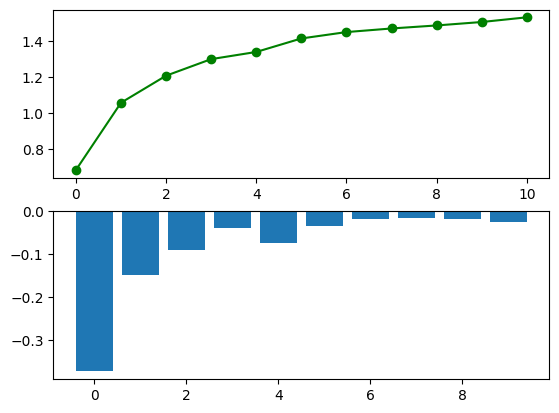

In [197]:
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
import numpy as np
from sklearn.cluster import KMeans
EuclDist = scipy.spatial.distance.euclidean
def gapStat(data,resf=None,nrefs=20,ks=range(1,12)):
    shape = data.shape
    if resf == None:
        x_max = data.max(axis=0)
        x_min = data.min(axis=0)
        dists = np.matrix(np.diag(x_max-x_min))
#         print(1)
        rands = np.random.random_sample(size=(shape[0],shape[1],nrefs))
        for i in range(nrefs):
#             print(i)
            rands[:,:,i] = rands[:,:,i]*dists+x_min
    else:
        rands = resf
    gaps = np.zeros((len(ks),))
    gapDiff = np.zeros(len(ks)-1,)
    sdk = np.zeros(len(ks),)
    for i,k in enumerate(ks):
        print(i)
        cluster = KMeans(n_clusters=k,random_state=0).fit(data)
        cluster_mean=cluster.cluster_centers_
        cluster_res = cluster.labels_
#         (cluster_mean,cluster_res) = scipy.cluster.vq.kmeans2(data,k)
        Wk = sum(EuclDist(data[m,:], cluster_mean[cluster_res[m],:]) for m in range(shape[0]))
        WkRef = np.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
#             (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j],k)
            cluster1 = KMeans(n_clusters=k,random_state=0).fit(rands[:,:,j])
            kmc=cluster1.cluster_centers_
            kml = cluster1.labels_
            WkRef[j] = sum([EuclDist(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
        gaps[i] = scipy.log(scipy.mean(WkRef))-scipy.log(Wk)
        sdk[i] = np.sqrt((1.0+nrefs)/nrefs)*np.std(scipy.log(WkRef))
        if i>0:
            gapDiff[i - 1] = gaps[i-1]-gaps[i] +sdk[i]
    return gaps, gapDiff
gaps,gapsDiff = gapStat(s)
%matplotlib inline
f, (a1,a2) = plt.subplots(2,1)
a1.plot(gaps, 'g-o')
a2.bar(np.arange(len(gapsDiff)),gapsDiff)
f.show()

In [190]:
print(cluster)

KMeans(n_clusters=10, random_state=0)


In [191]:
centroid=cluster.cluster_centers_
centroid 

array([[ 0.        ,  0.        , 10.92537313, ...,  2.6641791 ,
         5.22014925,  4.49626866],
       [ 0.        ,  0.        ,  2.26588398, ...,  1.10359116,
         2.10359116,  2.21063536],
       [ 0.        ,  0.        ,  5.70869565, ...,  1.17826087,
         2.75652174,  2.28695652],
       ...,
       [ 0.        ,  0.        ,  4.15444618, ...,  1.36037441,
         1.81981279,  2.07956318],
       [ 0.        ,  0.        ,  6.39962825, ...,  2.33271375,
         3.2472119 ,  3.15241636],
       [ 0.        ,  0.        ,  4.62684366, ...,  2.41740413,
         4.08259587,  3.76253687]])

In [195]:
y_pred = cluster.labels_
y_pred.shape

(4223,)

In [209]:
np.save('BikeNYCtimemeans',BikeNYCtimemeans)

In [5]:
C = np.load('adj.npy')
A = torch.Tensor(C)
B =A

for i in range(4222):
    print(i)
    B = torch.cat((B,A),axis=0)
print(B.shape)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16,8)) 
# plt.plot(C[:100,3])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085


3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724


In [6]:
np.save('adj',B)